In [4]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as sio
import scipy.stats as stats
from sklearn import preprocessing as preprocessing
from random import randrange

# Question 1: Logistic Regression with Newton's Method

In [5]:
X = np.array([[0, 3, 1], 
              [1, 3, 1], 
              [0, 1, 1], 
              [1, 1, 1]])
y = np.array([[1, 1, 0, 0]]).T
w0 = np.array([[-2, 1, 0]]).T
lmda = 0.07
n, d = 4, 2

## Question 1.4 (a)

In [7]:
s0 = sp.special.expit(np.dot(X, w0))
print(s0)

[[ 0.95257413]
 [ 0.73105858]
 [ 0.73105858]
 [ 0.26894142]]


In [16]:
I = np.eye(d+1, d+1)
# I[d, d] = 1
print(I)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


## Question 1.4 (b)

In [17]:
def w_iterate(w, X, s, y, lmda, d):
    grad = 2 * lmda * w + np.matmul(X.T, s - y)
    omega = np.diag(np.ndarray.flatten(s * (1 - s)))
    
    # don't penalize alpha
    I = np.eye(d+1, d+1)
#     I[d, d] = 1
    
    H = 2 * lmda * I + np.matmul(np.matmul(X.T, omega), X)
    e = np.linalg.solve(H, -grad)
    return w + e

In [18]:
w1 = w_iterate(w0, X, s0, y, lmda, d)
print(w1)

[[-0.38676399]
 [ 1.40431761]
 [-2.28417115]]


## Question 1.4 (c)

In [19]:
s1 = sp.special.expit(np.dot(X, w1))
print(s1)

[[ 0.87311451]
 [ 0.82375785]
 [ 0.29320813]
 [ 0.21983683]]


## Question 1.4 (d)

In [20]:
w2 = w_iterate(w1, X, s1, y, lmda, d)
print(w2)

[[-0.51222668]
 [ 1.45272677]
 [-2.16271799]]


# Question 4: Franzia Classification + Logistic Regression = Party!

In [4]:
wine_data = sio.loadmat("data.mat")

In [5]:
wine_X = wine_data['X']
wine_y = wine_data['y']
wine_X_test = wine_data['X_test']

# handle bias term for X
wine_X = np.insert(wine_X, wine_X.shape[1], 1, axis=1)
wine_X_test = np.insert(wine_X_test, wine_X_test.shape[1], 1, axis=1)

# normalize
wine_X = preprocessing.normalize(wine_X)
wine_y = preprocessing.normalize(wine_y)
wine_X_test = preprocessing.normalize(wine_X_test)

order = np.arange(wine_X.shape[0])
np.random.shuffle(order)

shuffled_wine_X = np.take(wine_X, order, 0)
shuffled_wine_y = np.take(wine_y, order, 0)

num_validation = 600
wine_tX = shuffled_wine_X[num_validation:]
wine_ty = shuffled_wine_y[num_validation:]

wine_vX = shuffled_wine_X[:num_validation]
wine_vy = shuffled_wine_y[:num_validation]

## Question 4.1: Batch Gradient Descent

In [245]:
SMALL = 1e-6

def logistic(X, w):
    s = sp.special.expit(np.dot(X, w))
    s[s == 0] = SMALL
    s[s == 1] = 1 - SMALL
    return s

def logistic_grad(w, X, y, reg_param):
    s = sp.special.expit(np.dot(X, w))
    s = np.reshape(s, (len(s), 1))
    return (2 * reg_param * w + np.dot(X.T, y - s)) / len(X)

def logistic_cost(w, X, y, lmda):
    s = logistic(X, w)
    norm = lmda * np.linalg.norm(w) ** 2
    log_cost = np.dot(y.T, np.log(s)) + np.dot((1-y).T, np.log(1-s))
    return ((norm - log_cost) / len(X))[0]

def batch_gradient_descent(X, y, reg_param, learning_rate, max_iter=float('inf')):
    i, costs = 0, []
    w = np.zeros((X.shape[1], 1))
    while (i < max_iter):
        if i % (max_iter // 1e2) == 0:
            costs.append(logistic_cost(w, X, y, learning_rate)[0])
        w = w + learning_rate * logistic_grad(w, X, y, reg_param)
        i += 1
    return costs, w    

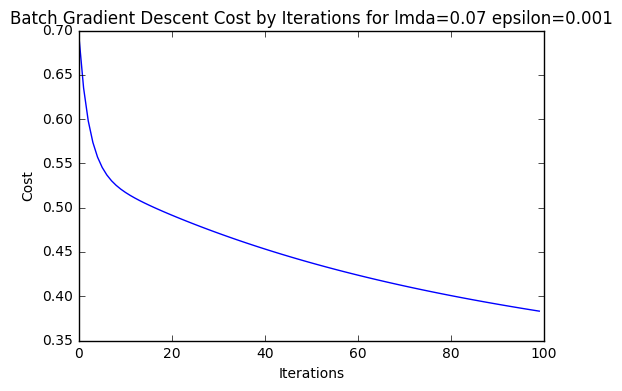

In [246]:
reg_param = 0.07
learning_rate = 1e-3
iterations = 1e5

batch_costs, batch_w = batch_gradient_descent(wine_tX, wine_ty, reg_param, learning_rate, iterations)

plt.plot(batch_costs)
plt.title('Batch Gradient Descent Cost by Iterations for lmda={} epsilon={}'.format(reg_param, learning_rate))
ax = plt.gca()

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('q41.png', bbox_inches='tight')
plt.show()


## Question 4.2: Stochastic Gradient Descent

In [255]:
def stochastic_logistic_grad(w, X, y, reg_param):
    ri = randrange(0, len(X))
    rx = X[ri]
    s = logistic(rx, w)[0]
    logis = rx.T * (y[ri][0] - s)
    logis = logis.reshape((len(w), 1))
    return 2 * reg_param * w + logis

def stochastic_gradient_descent(X, y, reg_param, learning_rate, max_iter=float('inf')):
    i, costs = 0, []
    w = np.zeros((X.shape[1], 1))
    while (i < max_iter):
        costs.append(logistic_cost(w, X, y, learning_rate)[0])
        w = w + learning_rate * stochastic_logistic_grad(w, X, y, reg_param)
        i += 1
    return costs, w

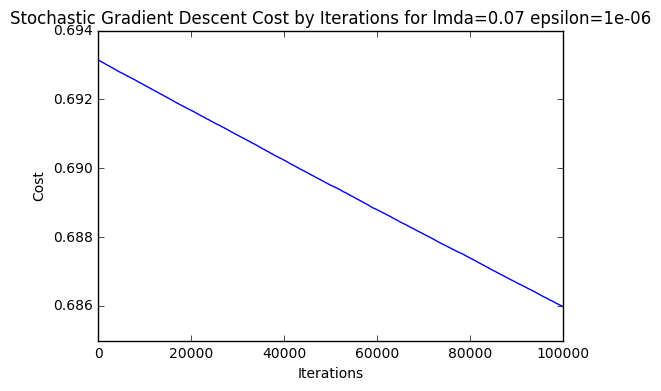

In [256]:
reg_param = 0.07
learning_rate = 1e-6
iterations = 1e5

stochastic_costs, stochastic_w = stochastic_gradient_descent(wine_tX, wine_ty, reg_param, learning_rate, iterations)

plt.plot(stochastic_costs)
plt.title('Stochastic Gradient Descent Cost by Iterations for lmda={} epsilon={}'.format(reg_param, learning_rate))
ax = plt.gca()

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('q42.png', bbox_inches='tight')
plt.show()

Stochastic gradient descent converges in less iterations that gradient descent

# Question 4.3: Stochastic Gradient Descent Non-constant Learning Rate

In [254]:
def decaying_stochastic_gradient_descent(X, y, reg_param, learning_rate, t, max_iter=float('inf')):
    i, costs = 0, []
    w = np.zeros((X.shape[1], 1))
    while (i < max_iter):
        costs.append(logistic_cost(w, X, y, learning_rate)[0])
        w = w + learning_rate * stochastic_logistic_grad(w, X, y, reg_param)
        i += 1
        learning_rate /= t
    return costs, w

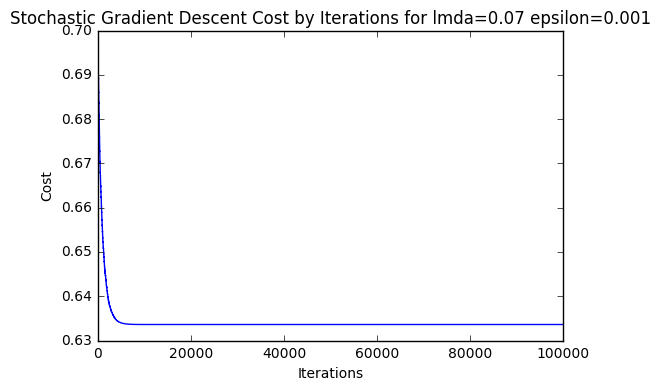

In [258]:
reg_param = 0.07
learning_rate = 1e-3
t = 1 + 1e-3
iterations = 1e5

stochastic_costs, dsw = decaying_stochastic_gradient_descent(wine_tX, wine_ty, reg_param, learning_rate, t, iterations)

plt.plot(stochastic_costs)
plt.title('Stochastic Gradient Descent Cost by Iterations for lmda={} epsilon={}'.format(reg_param, learning_rate))
ax = plt.gca()

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('q43.png', bbox_inches='tight')
plt.show()

After tuning our hyperparameters, it seems that having a decaying learning rate has lower costs. This strategy seems better, although after a certain point it essentially stops learning.

## Question 4.4 Kaggle

In [19]:
SMALL = 1e-6

def logistic_s(X, w):
    s = sp.special.expit(np.dot(X, w))
    s[s == 0] = SMALL
    s[s == 1] = 1 - SMALL
    return s

def logistic_grad(w, X, y, reg_param):
    s = logistic_s(X, w)
    s = np.reshape(s, (len(s), 1))
    return (2 * reg_param * w + np.dot(X.T, y - s) / len(X))

def batch_gradient_descent(X, y, reg_param, learning_rate, max_iter=float('inf')):
    i = 0
    w = np.zeros((X.shape[1], 1))
    while (i < max_iter):
        grad = logistic_grad(w, X, y, reg_param)
        w = w + learning_rate * grad
        i += 1
        if (i % (max_iter // 20) == 0):
            print(i)
    return w   

def lasso_logistic_grad(w, X, y, reg_param):
    s = logistic_s(X, w)
    s = np.reshape(s, (len(s), 1))
    return (reg_param + np.dot(X.T, y - s)) / len(X)

def lasso_batch_gradient_descent(X, y, reg_param, learning_rate, max_iter=float('inf')):
    i = 0
    w = np.zeros((X.shape[1], 1))
    while (i < max_iter):
        grad = lasso_logistic_grad(w, X, y, reg_param)
        w = w + learning_rate * grad
        i += 1
        if (i % (max_iter // 20) == 0):
            print(i)
    return w   

def logistic_hessian(w, X, y, reg_param):
    s = logistic_s(X, w)
    s = np.reshape(s, (len(s), 1))
    omega = np.diag(np.ndarray.flatten(s * (1 - s)))
    
    d = X.shape[1]
    I = np.eye(d, d)
    I[d-1, d-1] = 0
    
    return 2 * reg_param * I + np.matmul(np.matmul(X.T, omega), X)
    

def newton_update(w, X, y, lmda):
    grad = logistic_grad(w, X, y, lmda) 
    H = logistic_hessian(w, X, y, lmda)
    e = np.linalg.solve(H, -grad)
    return e

def newton_method(X, y, reg_param, learning_rate, max_iter=float('inf')):
    i = 0
    w = np.zeros((X.shape[1], 1))
    while (i < max_iter):
        w = w + newton_update(w, X, y, reg_param)
        i += 1
        if (i % (max_iter // 20) == 0):
            print(i)
    return w 

def predict(w, X):
    guesses = []
    for wine in X:
        guesses.append(logistic_s(wine, w)[0])
    return np.rint(guesses).astype(int)

In [22]:
reg_param = 0.07
learning_rate = 2e-3
iterations = 1e8

# train batch gradient descent on whole wine data
kaggle_w = lasso_batch_gradient_descent(wine_X, wine_y, reg_param, learning_rate, iterations)

5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000
65000000
70000000
75000000
80000000
85000000
90000000
95000000
100000000


In [23]:
print(kaggle_w)

[[ 67.65745382]
 [ 36.88947037]
 [ -6.60730614]
 [-17.10979866]
 [  8.28380708]
 [  4.07104519]
 [ -5.99795525]
 [  6.72517062]
 [ 38.54357397]
 [ 27.50144454]
 [-30.65613182]
 [  1.96160514]
 [  6.25210974]]


In [24]:
print(reg_param, learning_rate, iterations)
guesses = []
for wine in wine_X:
    a = logistic_s(wine, kaggle_w)
    guesses.append(a)
guesses = np.rint(guesses)

zeros, ones = 0, 0
for g in guesses:
    if g == 0:
        zeros += 1
    if g == 1:
        ones += 1
print(zeros, ones, zeros + ones)

wrong = 0
for g, label in zip(guesses, wine_y):
    if g != label:
        wrong += 1
accuracy = wrong / len(wine_y)
print(wrong, len(wine_y), accuracy)

0.07 0.002 100000000.0
4730 1270 6000
315 6000 0.0525


In [29]:
guesses = predict(kaggle_w, wine_X_test)

In [31]:
f = open('wine.csv', 'w')
f.write("Id,Category\n")
i = 0
for g in guesses:
    f.write("{},{}\n".format(i, g))
    i += 1
f.close()

Name: cschon

Score: 0.93952